# Problem Description
Given the data set of wind speeds, pitch angles, and powers from 2017 to 2020 for wind turbines `R80721` and `R80790`. Design a K-Nearest Neighbors (KNN) model that takes wind speed, desired power values as inputs and produces a recommended pitch angle value.

# Solution
## Define Input/ Output of KNN Model
### Inputs
* Wind speed value.
* **Desired** power value.

### Output
* Recommended pitch angle value.

## Define Implemention for KNN Model
* The data set of `R80721` and `R80790` are combined and categorized by `10` pitch angle value intervals.
* Value of `k` is `15`.
* Standardization formula is min-max normalization.
* Distance formula is Euclidean distance.
* Category selection method is to choose the category of highest weight, assuming that all k-nearest neighbors are similarly important. The weight of a category `A` is the sum of all reciprocals of distance between the new data and a given data whose category is `A`.

In [1]:
# import libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# define constants.
WIND_TURBINE_NAME_COLUMN_NAME = 'Wind_turbine_name'
WIND_SPEED_COLUMN_NAME = 'Ws'
PITCH_ANGLE_COLUMN_NAME = 'Ba'
POWER_COLUMN_NAME = 'P'
DISTANCE_COLUMN_NAME = 'Distance'

# Step 1. Prepare Data Set
## Step 1.1. Retrieve Data Set of Wind Turbines R80721 and R80790 (Wind Speed, Pitch Angle, and Power)

In [3]:
# extract data of wind turbines R80721 and R80790.
def get_my_wind_turbines_data(data_source_file_path, first_turbine_name, second_turbine_name):
    wind_turbines_data = pd.read_csv(data_source_file_path)
    loc_argument = (wind_turbines_data[WIND_TURBINE_NAME_COLUMN_NAME] == first_turbine_name) | (wind_turbines_data[WIND_TURBINE_NAME_COLUMN_NAME] == second_turbine_name)
    return wind_turbines_data.loc[loc_argument].reset_index()

my_wind_turbines_data = get_my_wind_turbines_data('wind_power_data_2017_2020.csv', 'R80721', 'R80790')
my_wind_turbines_data

,index,Wind_turbine_name,Date_time,Ba,Rt,DCs,Cm,P,Q,S,...,Ws2,Ws,Wa,Va,Ot,Nf,Nu,Rs,Rbt,Rm
0,0,R80721,2017/2/8 12:40,44.990002,14.860000,88.279999,3.10,-3.080000,0.010000,3.090000,...,1.95,1.90,343.280000,25.180000,5.30,49.980000,703.00000,0.84,21.040001,-336.720000
1,1,R80721,2017/2/8 14:40,44.990002,14.000000,23.320000,2.40,-1.810000,0.000000,1.810000,...,0.24,0.20,2.430000,44.310001,4.89,49.990002,704.63000,0.14,19.230000,0.000000
2,2,R80721,2017/2/8 15:00,44.990002,14.000000,38.369999,2.39,-1.890000,0.000000,1.890000,...,0.22,0.18,358.049990,39.939999,4.80,50.000000,698.40002,0.33,19.020000,-18.889999
3,3,R80721,2017/1/26 05:30,-1.000000,10.340000,1208.040000,1802.37,199.350010,16.389999,200.050000,...,5.42,4.91,61.540001,-1.900000,-6.42,50.009998,698.78003,11.52,23.000000,1571.050000
4,4,R80721,2017/1/26 07:40,-1.000000,9.979999,1005.250000,1171.28,92.589996,14.220000,93.709999,...,4.67,4.20,72.010002,8.530000,-7.30,50.000000,695.23999,9.58,21.459999,877.039980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108717,217583,R80790,2018/1/13 04:00,-1.000000,14.000000,1120.300000,1445.91,143.350000,26.340000,145.880000,...,4.78,4.72,44.530000,NaN,5.30,50.040000,703.32000,10.73,24.960000,1204.160000
108718,217584,R80790,2018/1/13 04:30,-0.810000,14.000000,965.580000,874.07,58.100000,19.350000,61.370000,...,4.14,4.05,45.660000,NaN,4.79,49.990000,701.00000,9.25,24.670000,570.680000
108719,217585,R80790,2018/1/13 04:40,-1.000000,14.000000,971.860000,1003.20,72.130000,20.610000,75.080000,...,4.46,4.36,50.890000,NaN,4.71,49.980000,699.73000,9.31,24.430000,703.790000
108720,217586,R80790,2018/1/13 04:50,-1.000000,14.000000,982.190000,1038.33,78.060000,21.300000,80.980000,...,4.76,4.60,59.480000,NaN,4.88,49.990000,699.38000,9.40,24.290000,753.530000


In [4]:
# extract wind speed, pitch angle, and power values of my wind turbines.
def get_ws_ba_p(wind_turbines_data):
    to_be_concatenated_object = [wind_turbines_data[WIND_SPEED_COLUMN_NAME],
                                 wind_turbines_data[PITCH_ANGLE_COLUMN_NAME],
                                 wind_turbines_data[POWER_COLUMN_NAME]]
    to_be_concatenated_keys = [WIND_SPEED_COLUMN_NAME,
                               PITCH_ANGLE_COLUMN_NAME,
                               POWER_COLUMN_NAME]
    return pd.concat(to_be_concatenated_object,
                     axis=1,
                     keys=to_be_concatenated_keys)

ws_ba_p = get_ws_ba_p(my_wind_turbines_data)
ws_ba_p = ws_ba_p.fillna(0) # fill NAs of the data set with 0s.
ws_ba_p

,Ws,Ba,P
0,1.90,44.990002,-3.080000
1,0.20,44.990002,-1.810000
2,0.18,44.990002,-1.890000
3,4.91,-1.000000,199.350010
4,4.20,-1.000000,92.589996
...,...,...,...
108717,4.72,-1.000000,143.350000
108718,4.05,-0.810000,58.100000
108719,4.36,-1.000000,72.130000
108720,4.60,-1.000000,78.060000


In [5]:
def plot_1d_array(chart_title, array):
    plt.title(chart_title)
    plt.xlabel('Indices')
    plt.ylabel('Values')
    plt.plot(array,
             linestyle='None',
             marker=',',
             color='b')
    plt.show()

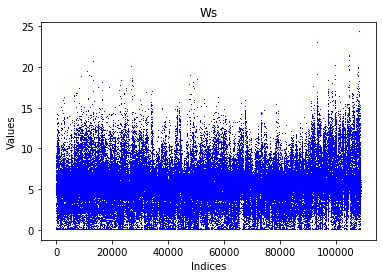

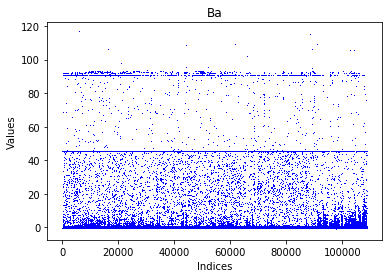

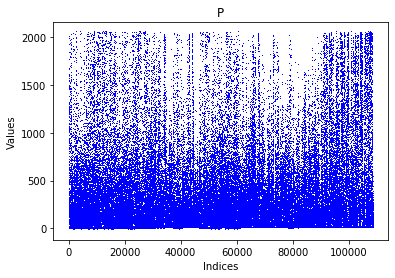

In [6]:
plot_1d_array(WIND_SPEED_COLUMN_NAME, ws_ba_p[WIND_SPEED_COLUMN_NAME])
plot_1d_array(PITCH_ANGLE_COLUMN_NAME, ws_ba_p[PITCH_ANGLE_COLUMN_NAME])
plot_1d_array(POWER_COLUMN_NAME, ws_ba_p[POWER_COLUMN_NAME])

# Step 1. Prepare Data Set
## Step 1.2. Categorize the Retrieved Data Set by 10 Pitch Angle Value Intervals

In [7]:
def get_pitch_angle_categorized_ws_ba_p(ws_ba_p):
    # define pitch angle categories values.
    categories_values = [-1, 5, 15, 25, 35, 50, 70, 85, 95, 100]
    # create pitch angle categories.
    bins = np.array([np.NINF, 0, 10, 20, 30, 40, 60, 80, 90, 100, np.Inf])
    ba_category_indices = np.digitize(ws_ba_p[PITCH_ANGLE_COLUMN_NAME].to_numpy(), bins, right=False) - 1
    ba_categories_values = []
    for ba_category_index in ba_category_indices:
        ba_categories_values.append(categories_values[ba_category_index])
    # clone the data for modification and return the result.
    pitch_angle_categorized_ws_ba_p = ws_ba_p.copy(deep=True)
    pitch_angle_categorized_ws_ba_p.loc[:, PITCH_ANGLE_COLUMN_NAME] = ba_categories_values
    return pitch_angle_categorized_ws_ba_p

ws_ba_p = get_pitch_angle_categorized_ws_ba_p(ws_ba_p)
ws_ba_p

,Ws,Ba,P
0,1.90,50,-3.080000
1,0.20,50,-1.810000
2,0.18,50,-1.890000
3,4.91,-1,199.350010
4,4.20,-1,92.589996
...,...,...,...
108717,4.72,-1,143.350000
108718,4.05,-1,58.100000
108719,4.36,-1,72.130000
108720,4.60,-1,78.060000


In [8]:
# set pitch angle categories.
pitch_angle_categories = ['-∞ ~ -1 (as -1)',
                          '0 ~ 9 (as 5)',
                          '10 ~ 19 (as 15)',
                          '20 ~ 29 (as 25)',
                          '30 ~ 39 (as 35)',
                          '40 ~ 59 (as 50)',
                          '60 ~ 79 (as 70)',
                          '80 ~ 89 (as 85)',
                          '90 ~ 99 (as 95)',
                          '100 ~ +∞ (as 100)']

In [9]:
def plot_pitch_angle_categorized_ws_ba_p(ws_ba_p, chart_horizontal_label, chart_vertical_label, chart_legends):
    # get the DataFrameGroupBy object.
    groups = ws_ba_p.groupby(PITCH_ANGLE_COLUMN_NAME)
    # create a new chart.
    figure, axes = plt.subplots()
    # plot data onto the chart.
    for name, group in groups:
        axes.plot(group[WIND_SPEED_COLUMN_NAME], group[POWER_COLUMN_NAME],
                  marker='.',
                  linestyle='None')
    # plot legends onto the chart.
    axes.legend(chart_legends)
    # set labels for the horizontal and vertical axes of the chart.
    axes.set(xlabel=chart_horizontal_label,
             ylabel=chart_vertical_label)
    # set the title for the chart.
    chart_title = 'Pitch Angle Categorized Data'
    axes.set_title(chart_title,
                   fontdict={'fontsize': 16,
                             'fontweight': 500,
                             'verticalalignment': 'baseline',
                             'horizontalalignment': 'center'},
                   pad=16.0)
    # show the chart.
    plt.show()
    # close the chart to free the memory.
    plt.close(figure)

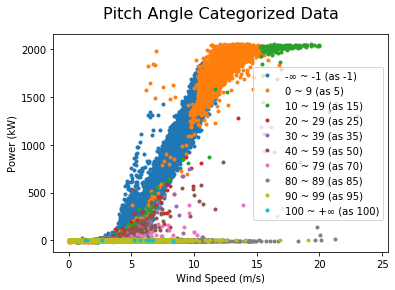

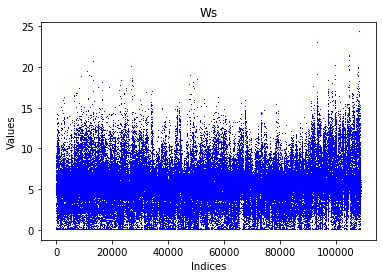

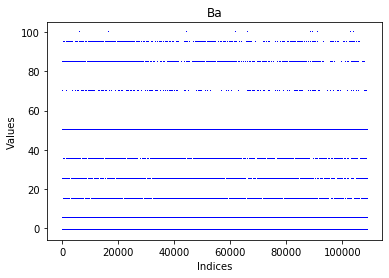

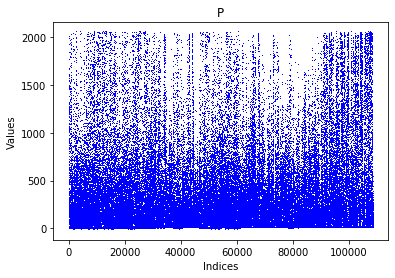

In [10]:
plot_pitch_angle_categorized_ws_ba_p(ws_ba_p, 'Wind Speed (m/s)', 'Power (kW)', pitch_angle_categories)
plot_1d_array(WIND_SPEED_COLUMN_NAME, ws_ba_p[WIND_SPEED_COLUMN_NAME])
plot_1d_array(PITCH_ANGLE_COLUMN_NAME, ws_ba_p[PITCH_ANGLE_COLUMN_NAME])
plot_1d_array(POWER_COLUMN_NAME, ws_ba_p[POWER_COLUMN_NAME])

# Step 1. Prepare Data Set
## Step 1.3. Standardize Wind Speed and Power Values of the Pitch Angle Categorized Data Set with Min-Max Normalization

In [11]:
# get minimum and maximum values of wind speed and power.
min_ws = ws_ba_p[WIND_SPEED_COLUMN_NAME].min()
max_ws = ws_ba_p[WIND_SPEED_COLUMN_NAME].max()
min_p = ws_ba_p[POWER_COLUMN_NAME].min()
max_p = ws_ba_p[POWER_COLUMN_NAME].max()

In [12]:
def get_min_max_normalization(x, min_x, max_x):
    return (x - min_x) / (max_x - min_x)

In [13]:
# standardize wind speed and power values of the given data using min-max normalization.
def get_wind_speed_and_power_min_max_normalized_ws_ba_p(ws_ba_p):
    wind_speed_and_power_min_max_normalized_ws_ba_p = ws_ba_p.copy(deep=True)
    wind_speed_and_power_min_max_normalized_ws_ba_p[WIND_SPEED_COLUMN_NAME] = get_min_max_normalization(ws_ba_p[WIND_SPEED_COLUMN_NAME], min_ws, max_ws)
    wind_speed_and_power_min_max_normalized_ws_ba_p[POWER_COLUMN_NAME] = get_min_max_normalization(ws_ba_p[POWER_COLUMN_NAME], min_p, max_p)
    return wind_speed_and_power_min_max_normalized_ws_ba_p

ws_ba_p = get_wind_speed_and_power_min_max_normalized_ws_ba_p(ws_ba_p)
ws_ba_p

,Ws,Ba,P
0,0.078286,50,0.006227
1,0.008241,50,0.006842
2,0.007417,50,0.006803
3,0.202307,-1,0.104174
4,0.173053,-1,0.052518
...,...,...,...
108717,0.194479,-1,0.077078
108718,0.166873,-1,0.035830
108719,0.179646,-1,0.042618
108720,0.189534,-1,0.045487


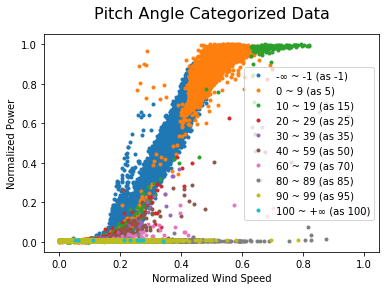

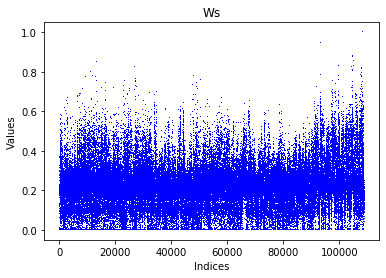

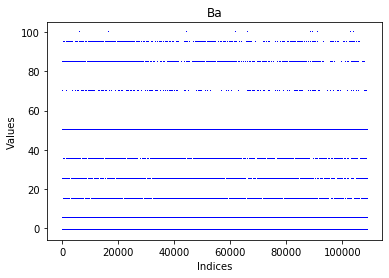

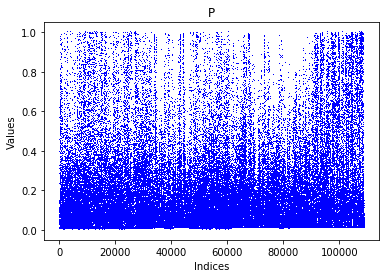

In [14]:
plot_pitch_angle_categorized_ws_ba_p(ws_ba_p, 'Normalized Wind Speed', 'Normalized Power', pitch_angle_categories)
plot_1d_array(WIND_SPEED_COLUMN_NAME, ws_ba_p[WIND_SPEED_COLUMN_NAME])
plot_1d_array(PITCH_ANGLE_COLUMN_NAME, ws_ba_p[PITCH_ANGLE_COLUMN_NAME])
plot_1d_array(POWER_COLUMN_NAME, ws_ba_p[POWER_COLUMN_NAME])

# Step 2. Input
* Wind speed value.
* **Desired** power value.

In [15]:
# input the wind speed and desired power values.
input_ws = 15
input_p = 1000

# standardize input data using min-max normalization.
input_ws = get_min_max_normalization(input_ws, min_ws, max_ws)
input_p = get_min_max_normalization(input_p, min_p, max_p)
input_ws_p = np.array((input_ws, input_p))
input_ws_p

array([0.61804697, 0.49157365])

# Step 3. Execute KNN Algorithm

In [16]:
def get_euclidean_distance_added_ws_ba_p(ws_ba_p):
    euclidean_distance_added_ws_ba_p = ws_ba_p.copy(deep=True)
    euclidean_distance_added_ws_ba_p[DISTANCE_COLUMN_NAME] = None
    for row_name in ws_ba_p.index:
        current_row_standardized_ws_p = np.array((ws_ba_p.at[row_name, WIND_SPEED_COLUMN_NAME],
                                                  ws_ba_p.at[row_name, POWER_COLUMN_NAME]))
        distance_value = np.linalg.norm(input_ws_p - current_row_standardized_ws_p)
        euclidean_distance_added_ws_ba_p.at[row_name, DISTANCE_COLUMN_NAME] = distance_value
    return euclidean_distance_added_ws_ba_p

ws_ba_p_distance = get_euclidean_distance_added_ws_ba_p(ws_ba_p)
ws_ba_p_distance

,Ws,Ba,P,Distance
0,0.078286,50,0.006227,0.725881
1,0.008241,50,0.006842,0.778992
2,0.007417,50,0.006803,0.779662
3,0.202307,-1,0.104174,0.568259
4,0.173053,-1,0.052518,0.625132
...,...,...,...,...
108717,0.194479,-1,0.077078,0.592635
108718,0.166873,-1,0.035830,0.641296
108719,0.179646,-1,0.042618,0.6275
108720,0.189534,-1,0.045487,0.61856


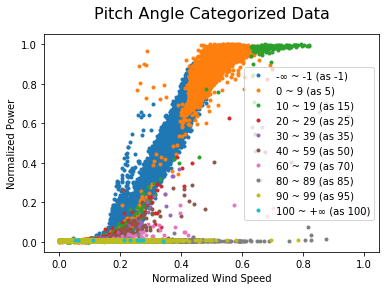

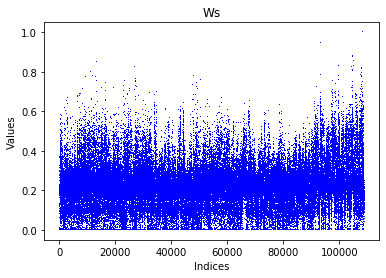

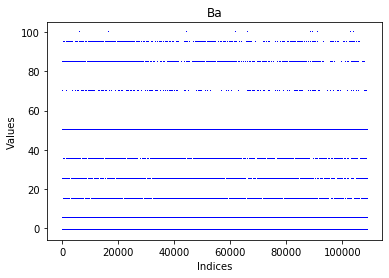

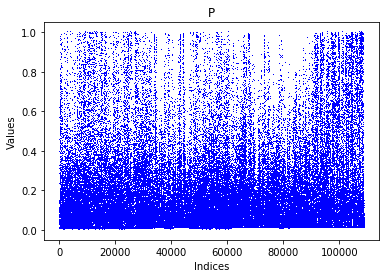

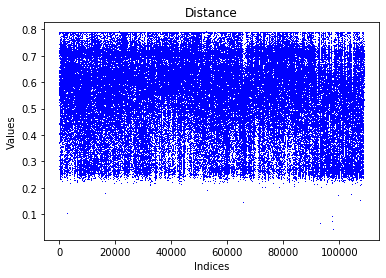

In [17]:
plot_pitch_angle_categorized_ws_ba_p(ws_ba_p_distance, 'Normalized Wind Speed', 'Normalized Power', pitch_angle_categories)
plot_1d_array(WIND_SPEED_COLUMN_NAME, ws_ba_p_distance[WIND_SPEED_COLUMN_NAME])
plot_1d_array(PITCH_ANGLE_COLUMN_NAME, ws_ba_p_distance[PITCH_ANGLE_COLUMN_NAME])
plot_1d_array(POWER_COLUMN_NAME, ws_ba_p_distance[POWER_COLUMN_NAME])
plot_1d_array(DISTANCE_COLUMN_NAME, ws_ba_p_distance[DISTANCE_COLUMN_NAME])

In [18]:
def get_ba_distance(ws_ba_p_distance):
    concat_object = [ws_ba_p_distance[PITCH_ANGLE_COLUMN_NAME],
                     ws_ba_p_distance[DISTANCE_COLUMN_NAME]]
    concat_keys = [PITCH_ANGLE_COLUMN_NAME,
                   DISTANCE_COLUMN_NAME]
    return pd.concat(concat_object, axis=1, keys=concat_keys)

ba_distance = get_ba_distance(ws_ba_p_distance)
ba_distance

,Ba,Distance
0,50,0.725881
1,50,0.778992
2,50,0.779662
3,-1,0.568259
4,-1,0.625132
...,...,...
108717,-1,0.592635
108718,-1,0.641296
108719,-1,0.6275
108720,-1,0.61856


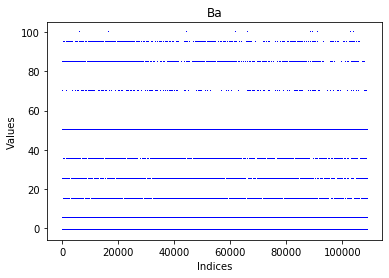

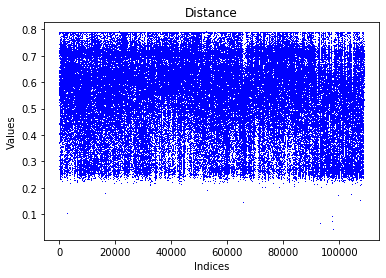

In [19]:
plot_1d_array(PITCH_ANGLE_COLUMN_NAME, ba_distance[PITCH_ANGLE_COLUMN_NAME])
plot_1d_array(DISTANCE_COLUMN_NAME, ba_distance[DISTANCE_COLUMN_NAME])

In [20]:
# sort data set ascendingly by distance.
sorted_ba_distance = ba_distance.sort_values(by=[DISTANCE_COLUMN_NAME])
sorted_ba_distance

,Ba,Distance
97749,35,0.0397704
93121,50,0.0605716
97255,50,0.068933
97252,35,0.0887298
2763,35,0.101091
...,...,...
22571,85,0.787423
22896,85,0.787459
47803,95,0.787558
52323,5,0.78884


In [21]:
# get KNN filter data.
knn_k = 15
knn_filtered_data = sorted_ba_distance.head(knn_k)
knn_filtered_data

,Ba,Distance
97749,35,0.0397704
93121,50,0.0605716
97255,50,0.068933
97252,35,0.0887298
2763,35,0.101091
65715,50,0.142145
107438,25,0.149823
99704,50,0.167074
104307,15,0.170574
16211,5,0.176577


In [22]:
def get_reciprocals_of_distance_knn_filtered_data(knn_filtered_data):
    result = knn_filtered_data.copy(deep=True)
    result[DISTANCE_COLUMN_NAME] = 1 / knn_filtered_data[DISTANCE_COLUMN_NAME]
    return result

knn_filtered_data = get_reciprocals_of_distance_knn_filtered_data(knn_filtered_data)
knn_filtered_data

,Ba,Distance
97749,35,25.1443
93121,50,16.5094
97255,50,14.5068
97252,35,11.2702
2763,35,9.89212
65715,50,7.03505
107438,25,6.67454
99704,50,5.98537
104307,15,5.86255
16211,5,5.66325


In [23]:
# calculate each category weight.
WEIGHT_COLUMN_NAME = 'Weight'
knn_weight = knn_filtered_data.groupby(by=[PITCH_ANGLE_COLUMN_NAME]).sum().reset_index().rename(columns={DISTANCE_COLUMN_NAME: WEIGHT_COLUMN_NAME})
knn_weight

,Ba,Weight
0,-1,15.122563
1,5,10.722081
2,15,5.862553
3,25,6.674537
4,35,46.306604
5,50,44.036650
6,70,5.390512


# Step 4. Output
* Recommended pitch angle value.

In [24]:
# output the recommended pitch angle value.
recommended_pitch_angle = knn_weight.at[knn_weight[WEIGHT_COLUMN_NAME].idxmax(), PITCH_ANGLE_COLUMN_NAME]
print('Recommended pitch angle value: ' + str(recommended_pitch_angle) + '°')

Recommended pitch angle value: 35°
